# DICE and Natural Capital

### 0. Prepare Environment

In [3]:
## Packages needed to run script
#using Pkg
#Pkg.update()
#Pkg.add("JuMP")
#Pkg.add("Ipopt")
##Pkg.add("Plots")
## Dataframe and excel:
##Pkg.add("DataFrames")
##Pkg.add("XLSX")

In [4]:
using JuMP, Ipopt, DataFrames, Plots

### 1. Set Parameters

#### 1.1 Constant Parameters

In [7]:
# Time parameters
n_periods      = 100                                    # Number of periods covered by model
period_length  = 5                                      # Lenght of periods in years
t              = collect(0:n_periods-1)                 # Time index running from 0 to n_periods-1
v              = t.+1                                   # Time index running from 1 to n_periods

# Welfare parameters
eta         =  1.0000001                                # Elasticity of marginal utility of consumption / inequality aversion parameter (Hänsel et al. 2020)
rho         =  0.005                                    # Rate of social time preference per YEAR (Hänsel et al. 2020 median expert view)

# Parameters of the economic production
Y_gross_0   =  105.177                                  # Initial output 2015 (trillion USD)
Y_gross_1   =  125.347                                  # Output in 2020 (trillion USD) DICE baseline
delta_K     =  0.1                                      # Capital depreciation factor per YEAR
gamma1      =  0.7                                      # Cobb-Douglas production function exponent(?)
#gamma2
#gamma3
gamma4      =  0.5                                

K_0         =  223                                      # Initial capital stock
L_0         =  7.403                                    # Initial labor force size (in billion)
A_0         =  5.115                                    # Initial level of total factor productivity (TFP)
g_A_0       =  0.076                                    # Initial growth rate for TFP
delta_A     =  0.005                                    # Decline rate of TFP 
g_L         =  0.134                                    # Growth rate of labor force per PERIOD
L_max       =  11.5                                     # Asymptotic limit of labor force size (in billion)

# Parameters of the emissions module
E_land_0    =  2.6                                      # Initial carbon emissions from land 2015 (GtCO2 per year)
delta_land  =  0.115                                    # Decline rate of land emissions (per period)
E_ind_0     =  35.740385                                # Initial industrial emissions 2015 (GtCO2)
E_ind_1     =  37.67871                                 # 2020 industrial emissions
mu_0        =  0.03                                     # Initial emissions control rate
sigma_0     =  E_ind_0/(Y_gross_0*(1-mu_0))             # Initial carbon intensity
g_sigma_0   = -0.0152                                   # Initial growth rate (decline) of carbon intensity 
d_sigma     = -0.001                                    # Decline rate of decarbonization per YEAR
CE_ind_0    =  1466.4                                   # Initial cumulative industrial emissions (GtCO2)
CE_land_0   =  722.202                                  # Initial cumulative emissions from land (GtCO2)
CE_0        =  CE_ind_0+CE_land_0                       # Initial total cumulative emissions (GtCO2)

# Parameters of the climate module
tcre        =  0.00045                                  # TCRE IPCC WG1 central value per GtCO2 (likely range: 0.00027-0.00063) (IPCC AR6 WG1 TS, p. 94)
adjnc       =  1.1                                      # Adjustment for non-CO2 emissions (1.1 from Dietz and Venmans 2019, p. 111,113)
T_0         =  1.128                                    # Initial temperature increase rel. to 1850-1900

# Parameter of the damage module
psi         = 0.007438;                                 # damage parameter: non-catastrophic damages from Howard and Sterner (2017)

# Parameters of the abatement module
p_backstop_0=  550                                      # Price of backstop technology for producing energy in 2010USD per tCO2 in 2015
g_p_backstop= -0.025                                    # Growth rate (decline) of backstop price per period
theta       =  2.6;                                     # Exponent of abatement cost function

#### 1.2 Time-Variant Parameters

In [9]:
# Discount factor for utility in welfare function
rr = 1 ./ ((1+rho).^(t * period_length))

# Labor
L = zeros(length(t))
L[1] = L_0
for i in t[2:length(t)]
    L[i+1] = L[i] * (L_max/L[i])^g_L
end

# TFP growth
g_A = zeros(length(t))
g_A[1] = g_A_0
for i in t[2:length(t)]
    g_A[i+1] = g_A[i] * exp(-delta_A*period_length)
end
A = zeros(length(t))
A[1] = A_0
for i in t[2:length(t)]
    A[i+1] = A[i]/(1-g_A[i])
end

# Exogenous emissions from land use (change)
E_land = E_land_0*(1-delta_land).^t

# Emission intensity
# development of emissions intensity growth rate as a vector:
g_sigma = g_sigma_0 * (1+d_sigma).^(t*period_length)
# create new vector with zeros inside:
sigma = zeros(length(t))
# define first element of vector with starting value for sigma:
sigma[1] = sigma_0
# calculate sigma for each time period after:
for i in t[2:length(t)]
    sigma[i+1] = sigma[i] * exp(g_sigma[i]*period_length)
end

# Backstop price
# Price of backstop technology
p_backstop = p_backstop_0 * (1+g_p_backstop).^t
p_hat_back = (p_backstop.*sigma)./theta/1000;    

### 2. Define Model

In [11]:
## Declare model to be optimized
DICEUpdate = JuMP.Model(Ipopt.Optimizer)
    
## Define model variables and bounds
@variables DICEUpdate begin
    
    # Discounted total welfare per period
    -Inf  <= W[v]          <= Inf

    # Production
    0     <= K[v]          <= Inf
    -Inf  <= Y_gross[v]    <= Inf
    -Inf  <= Y_net[v]      <= Inf
    -Inf  <= Y[v]          <= Inf
    
    # Investment
    0.001 <= I[v]          <= Inf

    # Consumption
    0.001 <= C[v]          <= Inf
    0.001 <= CPC[v]        <= Inf

    # Emissions
    -Inf  <= E_ind[v]      <= Inf
    -Inf  <= E[v]          <= Inf
    -Inf  <= CE_ind[v]     <= Inf
    -Inf  <= CE[v]         <= Inf

    # Climate
    -Inf  <= T[v]          <= Inf

    # Damages
    0.001 <= D_frac[v]     <= 1
    -Inf  <= D[v]          <= Inf

    # Abatement 
    0     <= mu[v]         <= 1.2
    -Inf  <= AC_frac[v]    <= Inf
    -Inf  <= AC[v]         <= Inf
    -Inf  <= p_carbon[v]   <= Inf
end

## Fix start values of variables
fix(K[1], K_0; force = true) # sets capital in first period to starting value
fix(Y_gross[2], Y_gross_1; force = true) # fixes output in 2020, because it is already over
fix(CE_ind[1], CE_ind_0; force = true)
fix(CE[1], CE_0; force = true)
fix(T[1], T_0; force = true)
fix(mu[1], mu_0; force = true)
fix(E_ind[2], E_ind_1; force = true)

## Define model equations
@constraints DICEUpdate begin
        
    # Discounted total welfare per period
    EQ_W[i in v],                      W[i]        == rr[i]*period_length*(CPC[i]^(1-eta))/(1-eta)*L[i]

    # Production market goods
    EQ_Y_gross[i in v],                Y_gross[i]  == A[i]*L[i]^(gamma1)*K[i]^(gamma2)*N[i]^(gamma3)
    EQ_Y_net[i in v],                  Y_net[i]    == (1-D_frac[i])*Y_gross[i]
    EQ_Y[i in v],                      Y[i]        == Y_net[i] - AC[i]

    # Production ecosystem services
    #EQ_E_gross [i in v],             E_gross[i]  == A[i]*L[i]^(gamma1)*K[i]^(gamma3)*N[i]^(gamma2)
    

    # Production non-use values
     #EQ_I_gross [i in v],             I_gross[i]  == N[i]^(gamma4)

    # Investment/Consumption trade-off
    EQ_C[i in v],                      C[i]        == Y[i]-I[i]

    # Consumption per capita
    EQ_c[i in v],                      CPC[i]      == C[i] / L[i]

    # Investment
    EQ_K[i in v[1:n_periods-1]],       K[i+1]      == K[i] * (1-delta_K)^period_length + period_length * I[i]

    # Emissions
    EQ_E_ind[i in v],                  E_ind[i]    == (1-mu[i])*sigma[i]*Y_gross[i]
    # feasibility constraint emissions reduction:
    EQ_E_ind2[i in v[2:6]],            E_ind[i+1]  >= E_ind[i] - 10
    EQ_E[i in v],                      E[i]        == E_ind[i] + E_land[i]
    EQ_CE_ind[i in v[1:n_periods-1]],  CE_ind[i+1] == CE_ind[i] + E_ind[i]*period_length
    EQ_CE[i in v[1:n_periods-1]],      CE[i+1]     == CE[i] + E[i]*period_length

    # Climate
    EQ_T[i in v[1:n_periods-1]],       T[i+1]      == tcre*adjnc*CE[i]

    # Damages
    EQ_D_frac[i in v],                 D_frac[i]   == psi*T[i]^2
    EQ_D[i in v],                      D[i]        == D_frac[i]*Y_gross[i]

    #damage function for natural capital
    #EQ_D ....                                      = D_frac[i]*NC

    # Abatement
    EQ_AC_frac[i in v],                AC_frac[i]  == p_hat_back[i] * mu[i]^theta
    EQ_AC[i in v],                     AC[i]       == AC_frac[i]*Y_gross[i]
    EQ_p_carbon[i in v],               p_carbon[i] == mu[i]^(theta-1)*p_backstop[i]
    # feasibility of abatement:        
    EQ_mu[i in v[2:6]],                mu[i+1]     <= 1
    EQ_mu2[i in v[7:n_periods-1]],     mu[i+1]     <= mu[i]*1.1 
    
end;

In [12]:
## Define model objective
@objective DICEUpdate Max begin
    welfare = sum(W[i] for i in v)
end;

### 3. Solve Model

In [14]:
# Optimize model
optimize!(DICEUpdate)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     4470
Number of nonzeros in inequality constraint Jacobian.:      200
Number of nonzeros in Lagrangian Hessian.............:      891

Total number of variables............................:     1893
                     variables with only lower bounds:      399
                variables with lower and upper bounds:      199
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1696
Total number of inequality c

In [15]:
termination_status(DICEUpdate)

LOCALLY_SOLVED::TerminationStatusCode = 4

### 4. Results

In [17]:
# Extract results
welfare  = objective_value(DICEUpdate)
W        = value.(W).data
Y_gross  = value.(Y_gross).data
Y_net    = value.(Y_net).data
Y        = value.(Y).data
C        = value.(C).data
CPC      = value.(CPC).data
K        = value.(K).data
I        = value.(I).data
E_ind    = value.(E_ind).data
E        = value.(E).data
CE_ind   = value.(CE_ind).data
CE       = value.(CE).data
T        = value.(T).data
D_frac   = value.(D_frac).data
D        = value.(D).data
mu       = value.(mu).data
AC_frac  = value.(AC_frac).data
AC       = value.(AC).data;

plot consumption, consumption per capita, investment and output only until the end of the 21st century

In [19]:
# if we are only interested in the 21st century:
Years = [2020:5:2100];

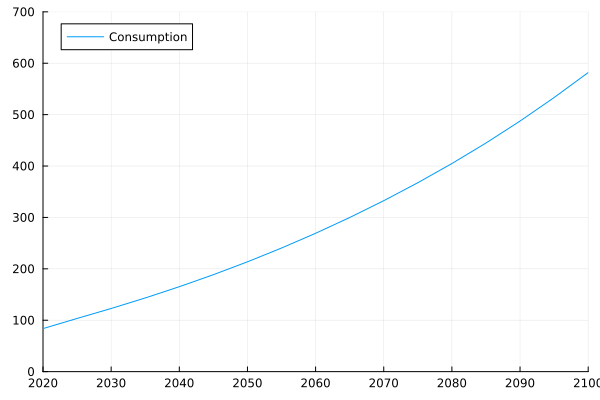

In [20]:
# plot the development of a variable until the end of the century
plot(Years, C[2:18], label="Consumption")
# change the y axis limits
ylims!(0,700) # ! is used as we are modifying the plot function
xlims!(2020,2100) # from 2020 to 2100
xticks!(2020:10:2100)

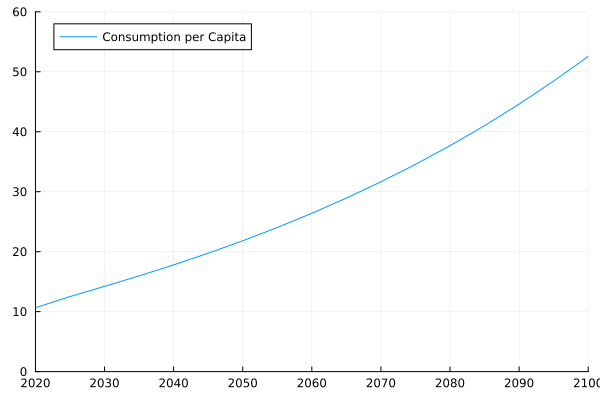

In [21]:
# plot the development of a variable until the end of the century
plot(Years, CPC[2:18], label="Consumption per Capita")
# change the y axis limits
ylims!(0,60) # ! is used as we are modifying the plot function
xlims!(2020,2100) # from 2020 to 2100
xticks!(2020:10:2100)

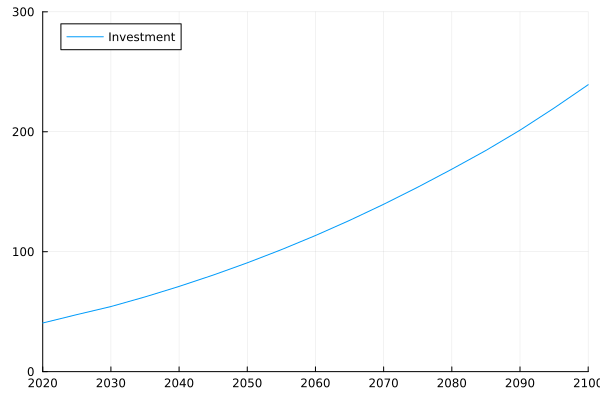

In [22]:
# plot the development of a variable until the end of the century
plot(Years, I[2:18], label="Investment")
# change the y axis limits
ylims!(0,300) # ! is used as we are modifying the plot function
xlims!(2020,2100) # from 2020 to 2100
xticks!(2020:10:2100)

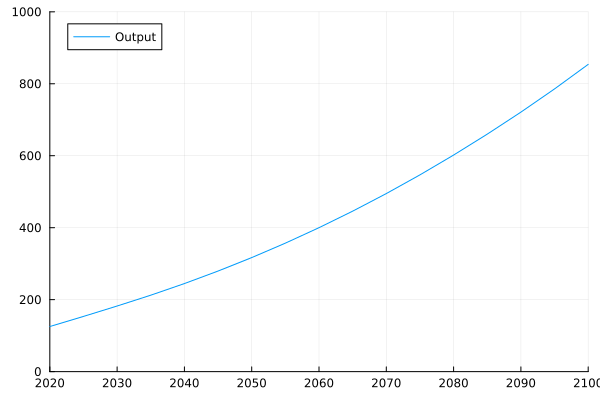

In [23]:
# plot the development of a variable until the end of the century
plot(Years, Y_gross[2:18], label="Output")
# change the y axis limits
ylims!(0,1000) # ! is used as we are modifying the plot function
xlims!(2020,2100) # from 2020 to 2100
xticks!(2020:10:2100)

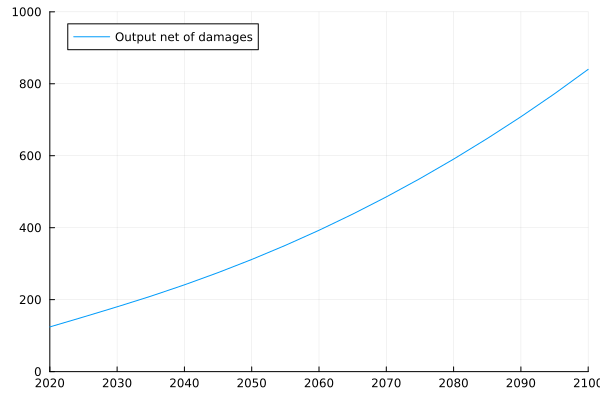

In [24]:
# plot the development of a variable until the end of the century
plot(Years, Y_net[2:18], label="Output net of damages")
# change the y axis limits
ylims!(0,1000) # ! is used as we are modifying the plot function
xlims!(2020,2100) # from 2020 to 2100
xticks!(2020:10:2100)

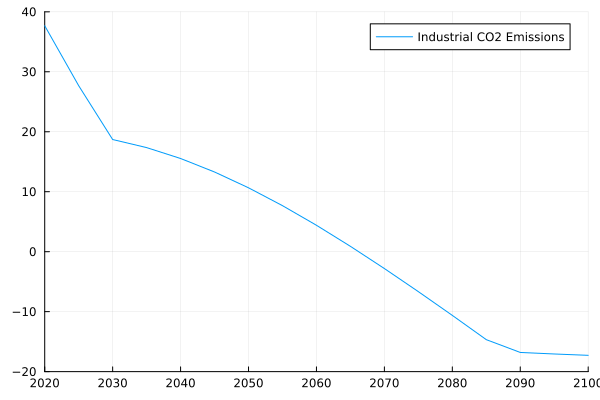

In [25]:
# plot the development of a variable until the end of the century
plot(Years, E_ind[2:18], label="Industrial CO2 Emissions")
# change the y axis limits
ylims!(-20,40) # ! is used as we are modifying the plot function
xlims!(2020,2100) # from 2020 to 2100
xticks!(2020:10:2100)

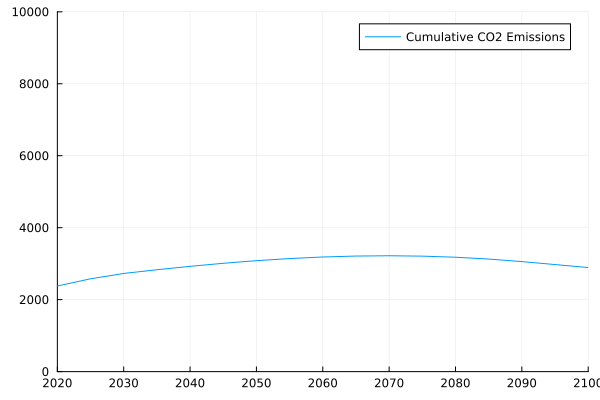

In [26]:
# plot the development of a variable until the end of the century
plot(Years, CE[2:18], label="Cumulative CO2 Emissions")
# change the y axis limits
ylims!(0,10000) # ! is used as we are modifying the plot function
xlims!(2020,2100) # from 2020 to 2100
xticks!(2020:10:2100)

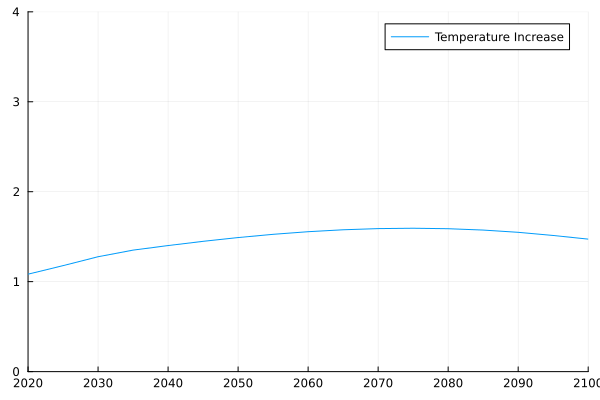

In [27]:
# plot the development of a variable until the end of the century
plot(Years, T[2:18], label="Temperature Increase")
# change the y axis limits
ylims!(0,4) # ! is used as we are modifying the plot function
xlims!(2020,2100) # from 2020 to 2100
xticks!(2020:10:2100)

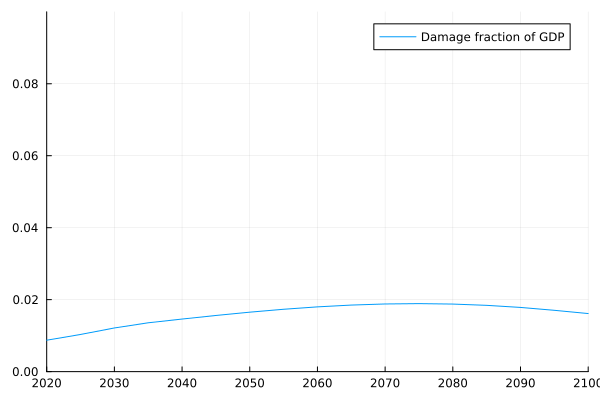

In [28]:
# plot the development of a variable until the end of the century
plot(Years, D_frac[2:18], label="Damage fraction of GDP")
# change the y axis limits
ylims!(0,0.1) # ! is used as we are modifying the plot function
xlims!(2020,2100) # from 2020 to 2100
xticks!(2020:10:2100)

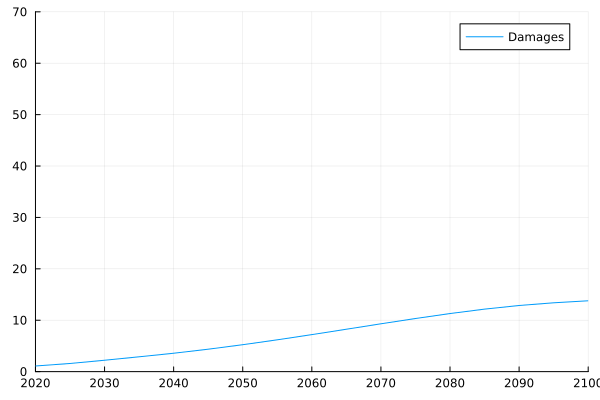

In [29]:
# plot the development of a variable until the end of the century
plot(Years, D[2:18], label="Damages")
# change the y axis limits
ylims!(0,70) # ! is used as we are modifying the plot function
xlims!(2020,2100) # from 2020 to 2100
xticks!(2020:10:2100)

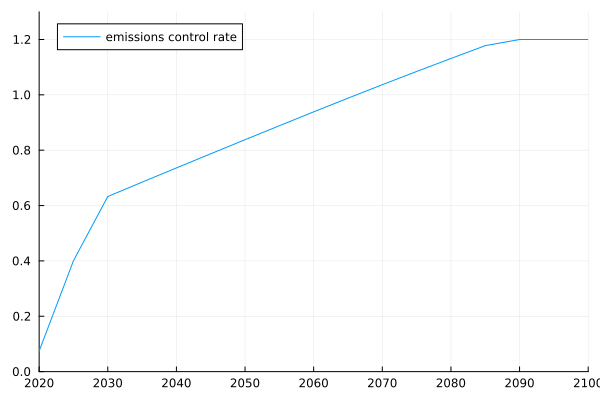

In [30]:
# plot the development of a variable until the end of the century
plot(Years, mu[2:18], label="emissions control rate")
# change the y axis limits
ylims!(0,1.3) # ! is used as we are modifying the plot function
xlims!(2020,2100) # from 2020 to 2100
xticks!(2020:10:2100)

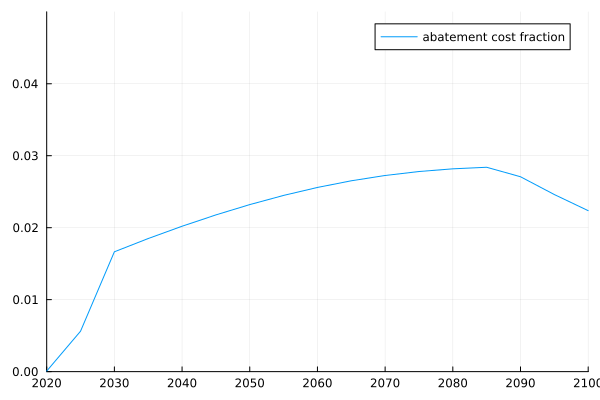

In [31]:
# plot the development of a variable until the end of the century
plot(Years, AC_frac[2:18], label="abatement cost fraction")
# change the y axis limits
ylims!(0,0.05) # ! is used as we are modifying the plot function
xlims!(2020,2100) # from 2020 to 2100
xticks!(2020:10:2100)

### 5. Save Parameters and Variables

In [33]:
# Save parameters and variables as dataframes

params_base = DataFrame(Parameters = ["n_periods", "period_length", "eta", "rho", "Y_gross_0", "Y_gross_1", "delta_K", 
                                       "gamma", "K_0", "L_0", "A_0", "g_A_0", "delta_A", "g_L", "L_max", "E_land_0", "delta_land",
                                       "E_ind_0", "sigma_0", "g_sigma_0", "d_sigma", "CE_ind_0", "CE_land_0", "CE_0", "tcre", 
                                        "adjnc", "T_0", "psi", "mu_0", "p_backstop_0", "g_p_backstop", "theta"],
    
                        Values = [n_periods, period_length, eta, rho, Y_gross_0, Y_gross_1, delta_K,
                                 gamma, K_0, L_0, A_0, g_A_0, delta_A, g_L, L_max, E_land_0, delta_land, 
                                 E_ind_0, sigma_0, g_sigma_0, d_sigma, CE_ind_0, CE_land_0, CE_0, tcre,
                                 adjnc, T_0, psi, mu_0, p_backstop_0, g_p_backstop, theta])

vars = DataFrame(t=t, W=W, Y_gross=Y_gross, Y_net=Y_net, Y=Y, C=C, A=A, L=L, K=K, I=I, E_land=E_land, E_ind=E_ind, E=E, CE_ind=CE_ind, CE=CE, T=T, D_frac=D_frac, D=D, AC_frac=AC_frac, AC=AC, mu=mu);

In [34]:
# Save as excel file

#import XLSX
#XLSX.writetable("DICEUpdate_Results.xlsx", "Parameters" => params_base, "Variables" => vars)